### 1. Importing libs

In [17]:
# General libs
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Datasets
dataset = '/mnt/e/DeepLearningDatasets/ChestXray/FinalDS/'

### 2. Visualizing the data

In [2]:
n_train = len(os.listdir(os.path.join(dataset,'train/normal'))) + len(os.listdir(os.path.join(dataset,'train/pneumonia')))
n_validate = len(os.listdir(os.path.join(dataset,'validation/normal'))) + len(os.listdir(os.path.join(dataset,'validation/pneumonia')))
n_test=len(os.listdir(os.path.join(dataset,'test/normal'))) + len(os.listdir(os.path.join(dataset,'test/pneumonia')))

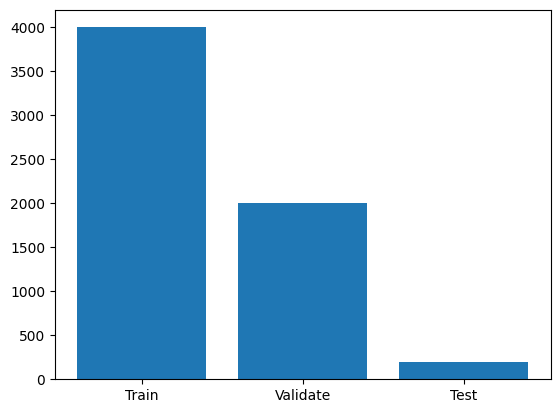

In [3]:
plt.bar(['Train', 'Validate', 'Test'],[n_train, n_validate, n_test])
plt.show()

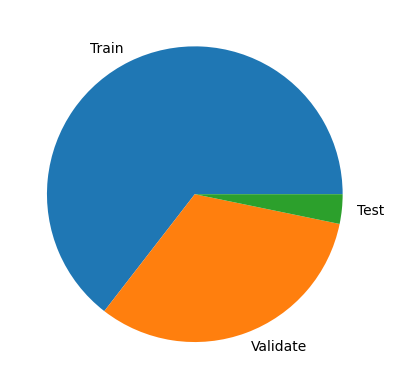

In [4]:
plt.pie([n_train, n_validate, n_test],labels=['Train', 'Validate', 'Test'])
plt.show()

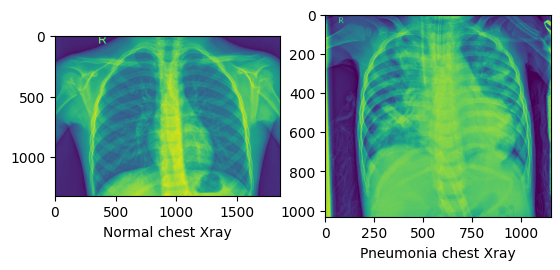

In [5]:
n_img = plt.imread(os.path.join(dataset,'train/normal/NORMAL_0.jpeg'))
p_img = plt.imread(os.path.join(dataset,'train/pneumonia/PNEUMONIA_0.jpeg'))
# plt.imshow(p_img)
# plt.show()

f, ax = plt.subplots(1, 2)
ax[0].imshow(n_img)
ax[1].imshow(p_img)
ax[0].set_xlabel("Normal chest Xray")
ax[1].set_xlabel("Pneumonia chest Xray")
plt.show()

### 3. Building data genrators

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, load_img, img_to_array

2023-05-08 17:03:49.588270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 17:03:49.749666: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-08 17:03:50.383428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/server/miniconda3/envs/tf/lib/:/home/server/miniconda3/envs/tf/lib/python3.9/site-packages/nvidia/cudnn/lib:/home/server/miniconda3/envs/tf/lib/:/home/server/miniconda3/envs/tf/lib/python3.9/site-packages/

##### Train generator

In [3]:
# Data augmentations
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 30,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.3,
    brightness_range = [0.4, 1.5],
)

In [4]:
train_dir = os.path.join(dataset,'train')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (200, 200),
    batch_size = 32,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = True
)

Found 4000 images belonging to 2 classes.


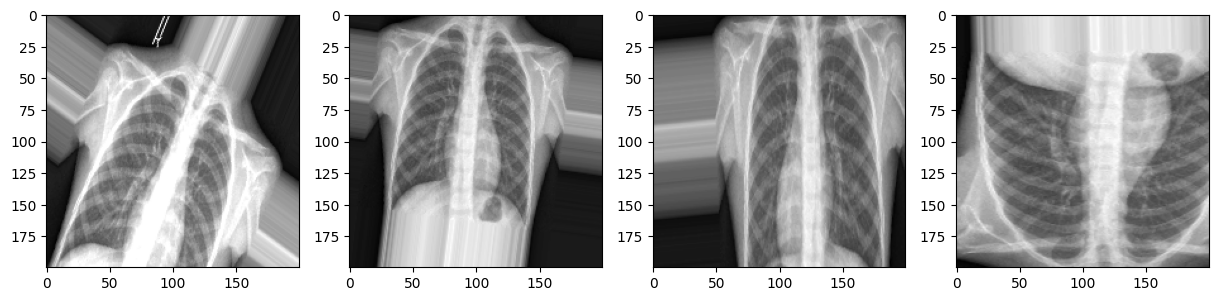

In [9]:
img = load_img(os.path.join(dataset,'train/normal/NORMAL_0.jpeg'), target_size = (200, 200))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 1
res = []
for batch in train_datagen.flow(x, batch_size = 1):
    if i % 5 == 0:
        break
    res.append(batch[0])
    i += 1

fig, ax = plt.subplots(1, 4, figsize=(15, 15))
ax[0].imshow(array_to_img(res[0]))
ax[1].imshow(array_to_img(res[1]))
ax[2].imshow(array_to_img(res[2]))
ax[3].imshow(array_to_img(res[3]))

##### Validation generator

In [5]:
validation_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 30,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.3,
    brightness_range = [0.4, 1.5],
)

In [6]:
validation_dir = os.path.join(dataset,'validation')
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (200, 200),
    batch_size = 32,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = True
)

Found 2000 images belonging to 2 classes.


##### Test generator

In [7]:
test_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 30,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.3,
    brightness_range = [0.4, 1.5],
)

In [8]:
test_dir = os.path.join(dataset,'test')
test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size = (200, 200),
    batch_size = 32,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = True
)

Found 200 images belonging to 2 classes.


### 4. Building model 

In [13]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
import visualkeras

##### CNN Model

In [26]:
model = Sequential()
model.add(Conv2D(16, 3, padding = 'same', activation = 'relu', input_shape = (200, 200, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1))

##### Compiling the model

In [27]:
from keras.losses import SparseCategoricalCrossentropy
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

##### Visualizing the model

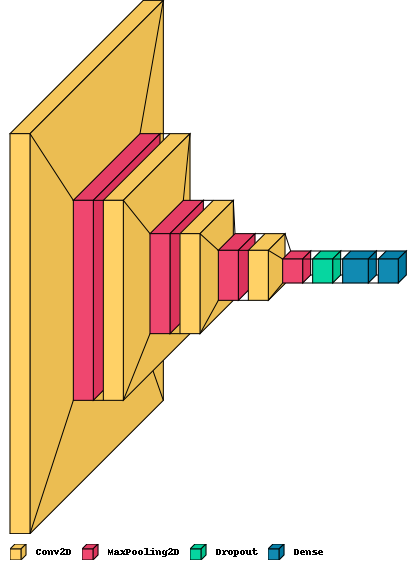

In [28]:
visualkeras.layered_view(model, scale_xy=2, legend=True)

In [29]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 20
)

Epoch 1/20
125/125 [==============================] - 436s 3s/step - loss: 0.7429 - accuracy: 0.4979 - val_loss: 0.6958 - val_accuracy: 0.4989
Epoch 2/20
125/125 [==============================] - 264s 2s/step - loss: 0.7027 - accuracy: 0.4997 - val_loss: 0.6945 - val_accuracy: 0.4998
Epoch 3/20
125/125 [==============================] - 263s 2s/step - loss: 0.7004 - accuracy: 0.4977 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 4/20
125/125 [==============================] - 265s 2s/step - loss: 0.6992 - accuracy: 0.4964 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 5/20
125/125 [==============================] - 256s 2s/step - loss: 0.6966 - accuracy: 0.5036 - val_loss: 0.6933 - val_accuracy: 0.4984
Epoch 6/20
125/125 [==============================] - 339s 3s/step - loss: 0.6969 - accuracy: 0.4926 - val_loss: 0.7041 - val_accuracy: 0.5000
Epoch 7/20
125/125 [==============================] - 312s 3s/step - loss: 0.6954 - accuracy: 0.5059 - val_loss: 0.6949 - val_accuracy: 0.5000

KeyboardInterrupt: 

##### As we can observe that the CNN is not very efficient in solving the problem. It seems from the output that the accuracy will not go above 50%. 

### 5. Using transfer learning 

In [9]:
from keras.applications import MobileNetV2

In [10]:
feature_extractor = MobileNetV2(
    input_shape = (200, 200, 3),
    weights = 'imagenet',
    include_top = False,
    pooling = 'avg'
)
feature_extractor.trainable = False

2023-05-08 17:04:18.068826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 17:04:18.112632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 17:04:18.113135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 17:04:18.113925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [11]:
from keras import Model

In [14]:
inputs = feature_extractor.input
x = Dense(128, activation = 'relu')(feature_extractor.output)
x = Dense(128, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = Model(inputs = inputs, outputs = outputs)

In [15]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'] 
)

In [16]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 10
)

Epoch 1/10


2023-05-08 17:04:57.200965: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2023-05-08 17:04:59.030524: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 17:04:59.274971: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 17:04:59.275114: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-08 17:04:59.514235: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 17:04:59.514546: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


125/125 [==============================] - 273s 2s/step - loss: 0.2844 - accuracy: 0.8792 - val_loss: 0.3981 - val_accuracy: 0.8330
Epoch 2/10
125/125 [==============================] - 283s 2s/step - loss: 0.2468 - accuracy: 0.8975 - val_loss: 0.3315 - val_accuracy: 0.8665
Epoch 3/10
125/125 [==============================] - 259s 2s/step - loss: 0.2302 - accuracy: 0.9078 - val_loss: 0.4665 - val_accuracy: 0.8095
Epoch 4/10
125/125 [==============================] - 266s 2s/step - loss: 0.2008 - accuracy: 0.9208 - val_loss: 0.3262 - val_accuracy: 0.8730
Epoch 5/10
125/125 [==============================] - 260s 2s/step - loss: 0.1960 - accuracy: 0.9202 - val_loss: 0.3207 - val_accuracy: 0.8670
Epoch 6/10
125/125 [==============================] - 250s 2s/step - loss: 0.1843 - accuracy: 0.9300 - val_loss: 0.3229 - val_accuracy: 0.8700
Epoch 7/10
125/125 [==============================] - 247s 2s/step - loss: 0.1810 - accuracy: 0.9270 - val_loss: 0.3431 - val_accuracy: 0.8520
Epoch 8/10

<Axes: >

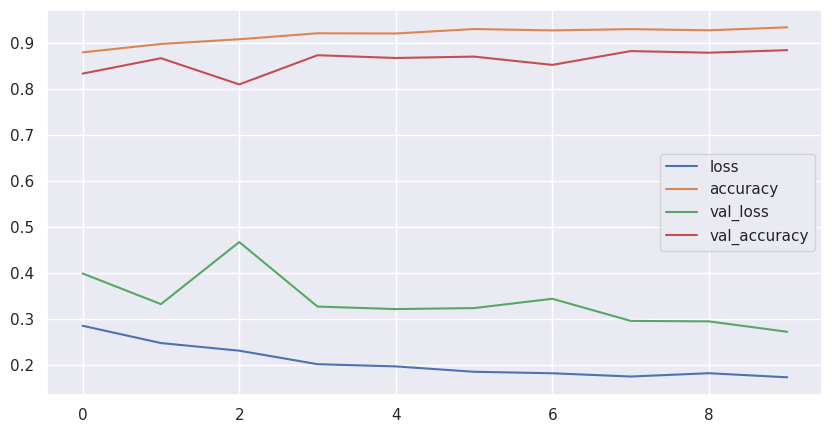

In [18]:
pd.DataFrame(history.history).plot(figsize=(10,5))

##### Evaluating the model

In [19]:
model.evaluate(test_generator)

7/7 [==============================] - 14s 2s/step - loss: 0.3053 - accuracy: 0.8750


[0.3053472638130188, 0.875]

##### Saving the model

In [20]:
model.save('trained_model.h5')

### Conclusion

<p>The transfer learning model performs way better than the custom CNN so this will be the output model.</p>

### 6. Predict using the model

In [29]:
from keras.utils import load_img, img_to_array
from tensorflow import keras
from keras.applications.resnet_v2 import preprocess_input

In [31]:
classes = ['NORMAL', 'PNEUMONIA']

pred_path = os.path.join(dataset, 'pred')
fnames_n = ['NORMAL_{}.jpeg'.format(i) for i in range(1,5)]
res_n = []
for fname in fnames_n:
    file_path = os.path.join(pred_path+'/NORMAL',fname)
    img = load_img(file_path, target_size=(200,200,3))
    img_arr = img_to_array(img)
    img_final = preprocess_input(img_arr)
    img_final = np.expand_dims(img_final, axis=0)
    res_n.append(model.predict(img_final))
res_n
    
    

1/1 [==============================] - 0s 44ms/step


[array([[0.0028053]], dtype=float32),
 array([[0.00189011]], dtype=float32),
 array([[0.00216757]], dtype=float32),
 array([[0.03060286]], dtype=float32)]

Text(0.5, 0, 'Actual: Normal / Predicted: [[0.19610141]]')

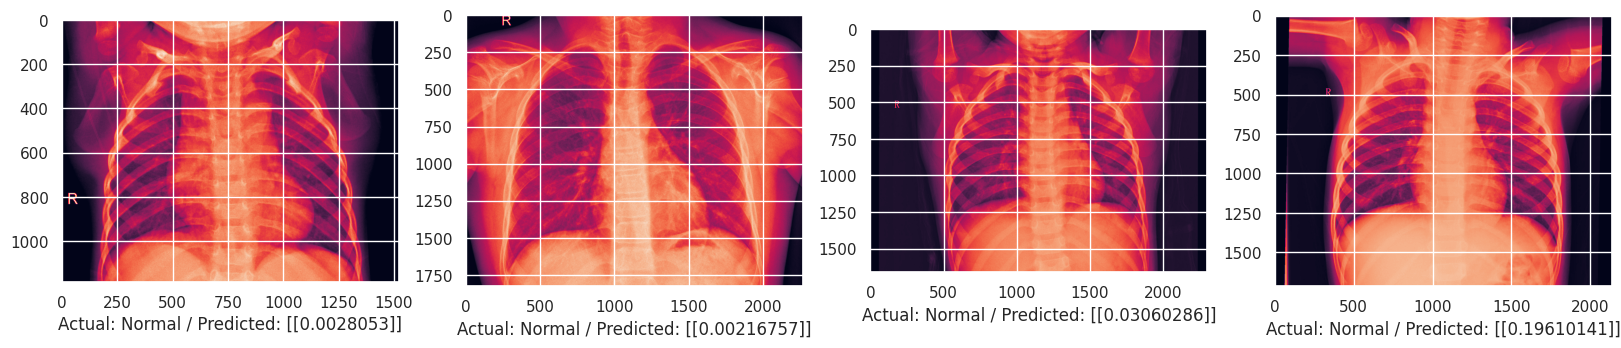

In [56]:
fig, ax = plt.subplots(1,4, figsize=(20,20))

ax[0].imshow(plt.imread(pred_path+'/NORMAL/'+fnames_n[0]))
ax[1].imshow(plt.imread(pred_path+'/NORMAL/'+fnames_n[1]))
ax[2].imshow(plt.imread(pred_path+'/NORMAL/'+fnames_n[2]))
ax[3].imshow(plt.imread(pred_path+'/NORMAL/'+fnames_n[3]))

ax[0].set_xlabel('Actual: Normal / Predicted: {}'.format(res_n[0]))
ax[1].set_xlabel('Actual: Normal / Predicted: {}'.format(res_n[2]))
ax[2].set_xlabel('Actual: Normal / Predicted: {}'.format(res_n[3]))
ax[3].set_xlabel('Actual: Normal / Predicted: {}'.format(res_n[4]))

In [42]:
fnames_p = ['PNEUMONIA_{}.jpeg'.format(i) for i in range(1,5)]
res_p = []
for fname in fnames_p:
    file_path = os.path.join(pred_path+'/PNEUMONIA',fname)
    img = load_img(file_path, target_size=(200,200,3))
    img_arr = img_to_array(img)
    img_final = preprocess_input(img_arr)
    img_final = np.expand_dims(img_final, axis=0)
    res_p.append(model.predict(img_final))
res_p

1/1 [==============================] - 0s 31ms/step


[array([[0.19610141]], dtype=float32),
 array([[0.9392065]], dtype=float32),
 array([[0.30502155]], dtype=float32),
 array([[0.49474388]], dtype=float32)]

Text(0.5, 0, 'Actual: PNEUMONIA / Predicted: [[0.49474388]]')

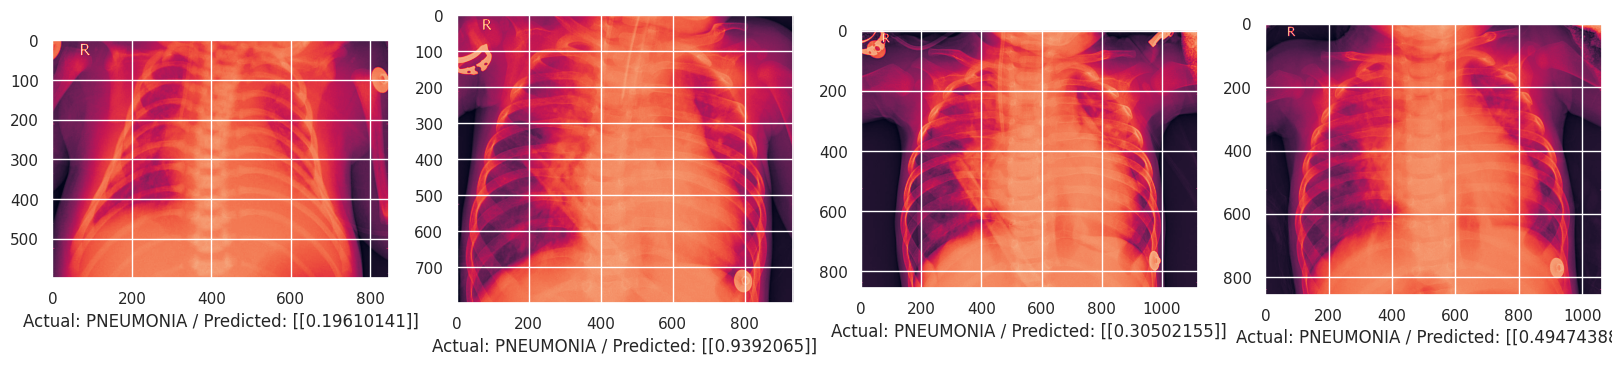

In [57]:
fig, ax = plt.subplots(1,4, figsize=(20,20))

ax[0].imshow(plt.imread(pred_path+'/PNEUMONIA/'+fnames_p[0]))
ax[1].imshow(plt.imread(pred_path+'/PNEUMONIA/'+fnames_p[1]))
ax[2].imshow(plt.imread(pred_path+'/PNEUMONIA/'+fnames_p[2]))
ax[3].imshow(plt.imread(pred_path+'/PNEUMONIA/'+fnames_p[3]))

ax[0].set_xlabel('Actual: PNEUMONIA / Predicted: {}'.format(res_p[0]))
ax[1].set_xlabel('Actual: PNEUMONIA / Predicted: {}'.format(res_p[1]))
ax[2].set_xlabel('Actual: PNEUMONIA / Predicted: {}'.format(res_p[2]))
ax[3].set_xlabel('Actual: PNEUMONIA / Predicted: {}'.format(res_p[3]))

1.0